# Data Driven Intrusion Detection: an Exploratory Analysis


We analyse a dataset that was generated collecting 2000 pings on 7 A8-nodes running an RPL instance. We start our analysis importing relevant informations from each node.

In [44]:
from matplotlib import pyplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

nodes = {} # <a8_node, [time in ms for each icmp message]>
ips = {}  # <a8_node, IP6>
icmp = [n for n in range(1,2001)]   # Produce a sequence of ICMP numbers

for file in os.listdir("data"):
    if file.split('.')[0].isdigit():
        with open('data/' + file, 'r') as f:
            lines = f.read().split('\n')
            node = 'A8-'+ file.split('.')[0]
            
            for line in lines:
                line = line.split()
                if len(line) <= 1:
                    continue
                    
                # Import IPs
                if line[0] == 'ping6':
                    ip = line[2].split('ping6')[0][:29]
                    if file not in ips:
                        ips[node] = ip
                elif line[0] == '>' and line[1] == 'ping6':
                    ip = line[3].split('ping6')[0][:29]
                    if file not in ips:
                        ips[node] = ip
                        
                        
                # Import all data
                if line[0] == '12':
                    if node not in nodes:
                        nodes[node] = [float(line[-2])]
                    else:
                        nodes[node].append(float(line[-2]))
                elif line[0] == 'ping' and line[1] == 'timeout':
                    if node not in nodes:
                        nodes[node] = [-1.0]
                    else:
                        nodes[node].append(-1.0)
                    
nodes = pd.DataFrame(nodes) 
nodes = nodes[sorted(nodes.columns.tolist())]
nodes.head(10)

,A8-156,A8-163,A8-173,A8-183,A8-193,A8-204
0,7.536,-1.000,12.267,-1.000,28.567,-1.0
1,8.490,20.823,11.627,33.983,0.648,-1.0
2,10.090,15.458,14.822,43.245,0.648,-1.0
3,10.730,11.053,13.221,55.357,0.650,-1.0
4,9.450,32.374,13.861,-1.000,0.648,-1.0
5,9.136,17.303,-1.000,-1.000,42.306,-1.0
6,8.811,14.498,10.672,31.147,0.648,-1.0
7,8.177,19.863,10.990,21.627,0.648,-1.0
8,8.811,16.098,7.858,38.739,0.648,-1.0
9,9.770,9.453,8.818,-1.000,0.648,-1.0


Each node communicates with the root of the DODAG through a certain number of hops. The network was configured in order to have three nodes communicating directly with the root, two node at distance 2 and just one node that was at distance 3 from node 'A8-149'.

In [45]:
hops = {1: ['A8-156','A8-163','A8-173'],\
       2: ['A8-183','A8-193'],\
       3: ['A8-204']}


# Contain mean time for each distance from the root

hop_nodes = pd.DataFrame({1: nodes[hops[1]].mean(axis=1), 2: nodes[hops[2]].mean(axis=1),\
                           3: nodes[hops[3]].mean(axis=1)})
hop_nodes.head(10)

,1,2,3
0,6.267667,13.7835,-1.0
1,13.646667,17.3155,-1.0
2,13.456667,21.9465,-1.0
3,11.668000,28.0035,-1.0
4,18.561667,-0.1760,-1.0
5,8.479667,20.6530,-1.0
6,11.327000,15.8975,-1.0
7,13.010000,11.1375,-1.0
8,10.922333,19.6935,-1.0
9,9.347000,-0.1760,-1.0


For each node we plot the graph that measures the delay with respect to the number of sequence.

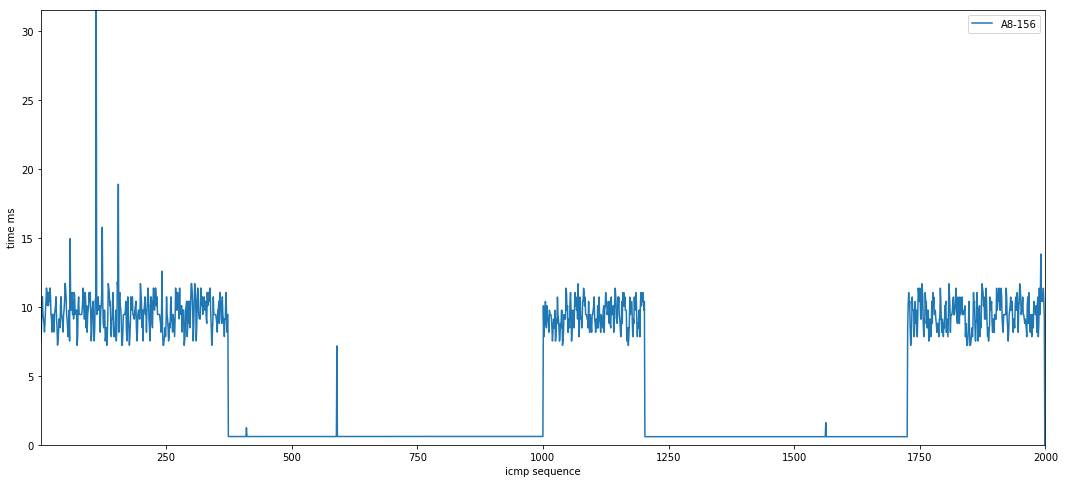

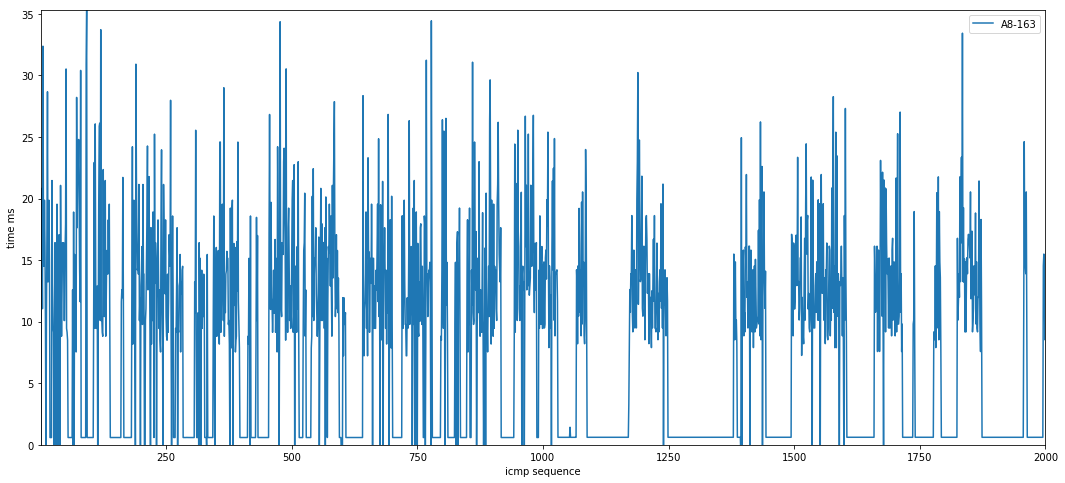

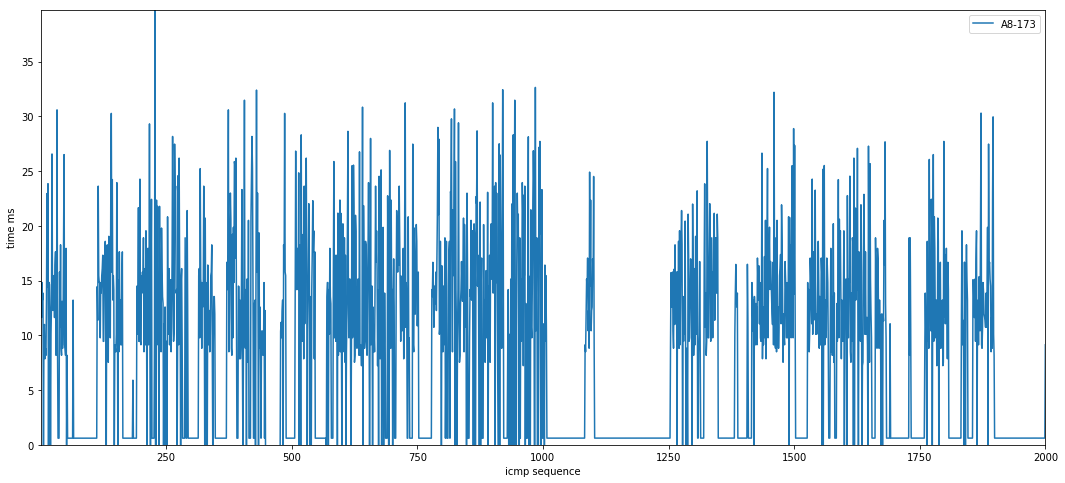

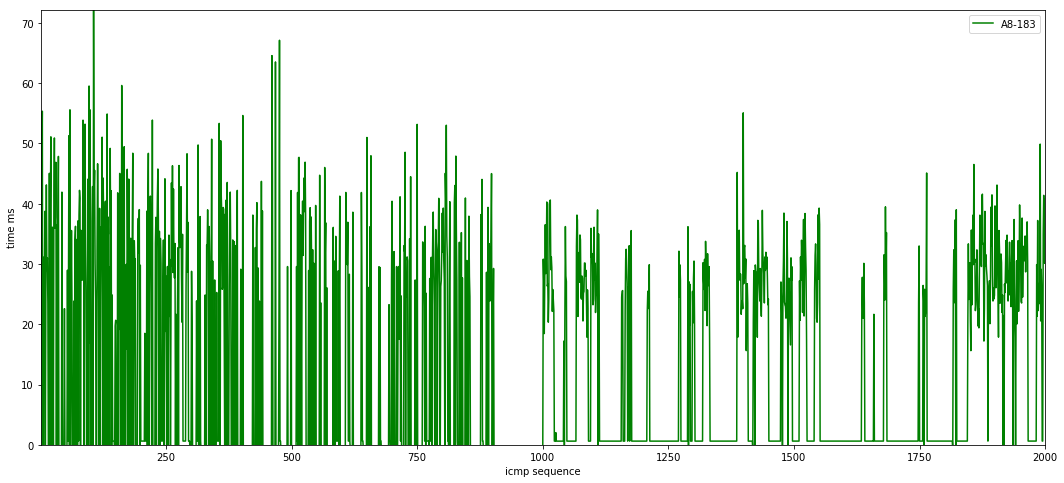

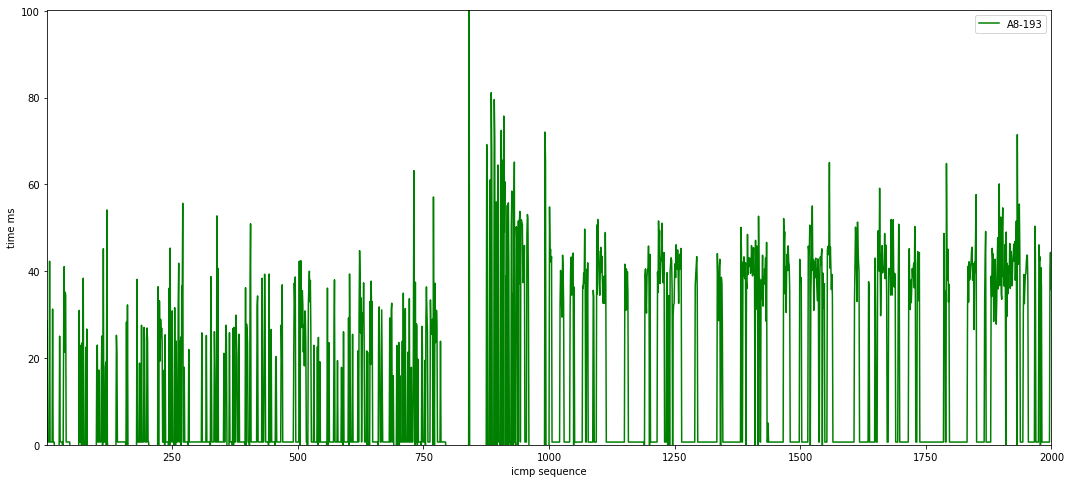

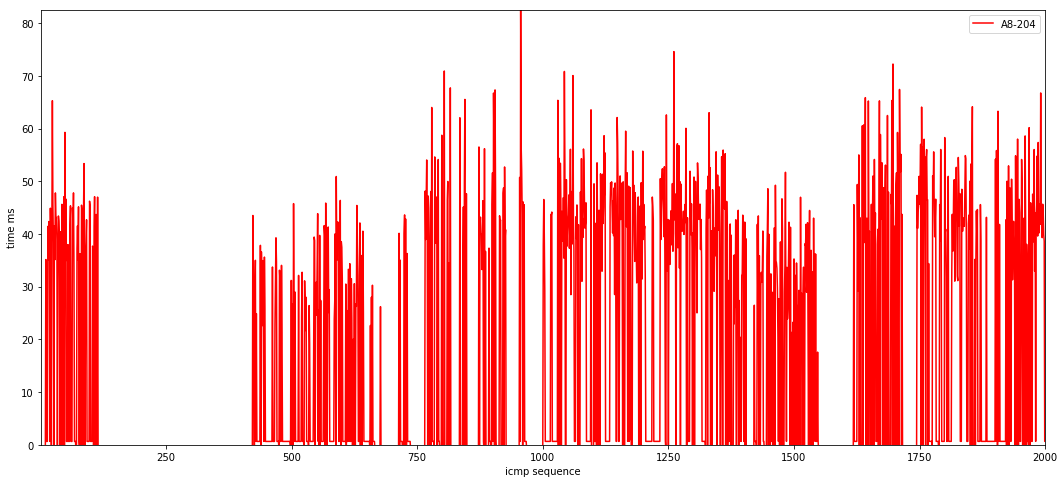

In [46]:
for node in nodes.keys():
    tms = nodes[node]
    
    plt.figure(figsize=(18,8))
    plt.ylabel('time ms')
    plt.xlabel('icmp sequence')
    
    if node in hops[1]:
        plt.plot(icmp, tms, label=node)
    elif node in hops[2]:
        plt.plot(icmp, tms, 'green', label=node)
    else:
        plt.plot(icmp, tms, 'red', label=node)

    plt.axis([1,icmp[-1], 0.0, sorted(tms)[-1]])
    plt.legend()
    plt.show()

Let us see how does the delay change with respect to the distance from the root.

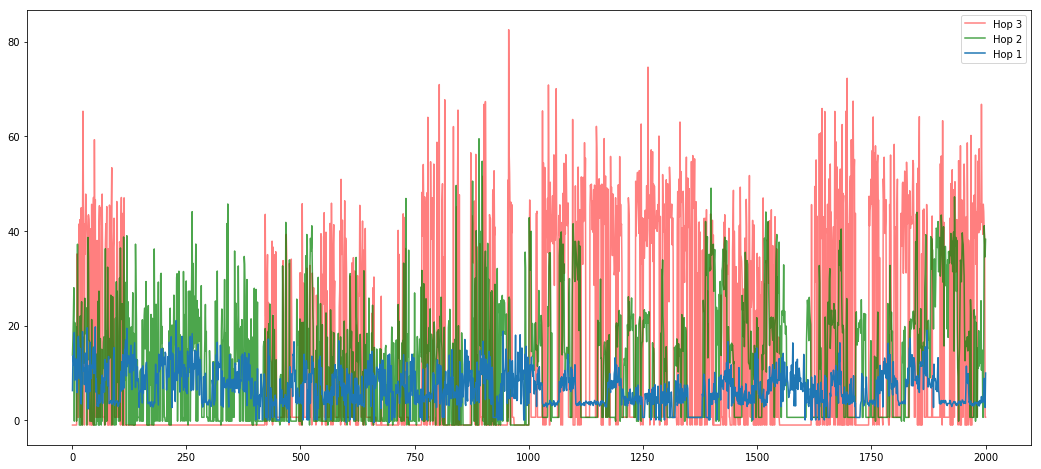

In [47]:
fig, ax = plt.subplots(figsize=(18,8))

# Using plot(..., dashes=...) to set the dashing when creating a line
line3, = ax.plot(icmp, hop_nodes[3], 'red', alpha=0.5, label='Hop 3')

# Using plot(..., dashes=...) to set the dashing when creating a line
line2, = ax.plot(icmp, hop_nodes[2], 'green', alpha=0.7, label='Hop 2')

# Using set_dashes() to modify dashing of an existing line
line1, = ax.plot(icmp, hop_nodes[1], label='Hop 1')

ax.legend()
plt.show()

It is also useful to read some statistics from the dataset. For each node:

In [50]:
nodes.describe()

,A8-156,A8-163,A8-173,A8-183,A8-193,A8-204
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4.393375,7.732842,8.107352,11.556494,12.586212,15.108949
std,4.509685,7.817547,8.349274,16.198730,18.776377,21.350321
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.589000,0.609000,0.611000,-1.000000,0.630000,-1.000000
50%,0.605000,8.213000,8.336000,0.616000,0.648000,0.642000
75%,9.129000,13.862000,14.498000,27.048250,31.016000,38.061750
max,31.525000,35.319000,39.722000,72.160000,100.208000,82.513000


For each hop:

In [51]:
hop_nodes.describe()

,1,2,3
count,2000.000000,2000.000000,2000.000000
mean,6.744523,12.071353,15.108949
std,3.830133,12.424590,21.350321
min,-0.466667,-1.000000,-1.000000
25%,3.744833,0.620000,-1.000000
50%,6.191000,12.254500,0.642000
75%,9.237667,20.227250,38.061750
max,21.077333,59.477500,82.513000


Now we use a Kernel density estimation (a way to estimate the probability density function of a random variable in a non-parametric way). It is useful to plot also a histogram in order to study the distribution of data.

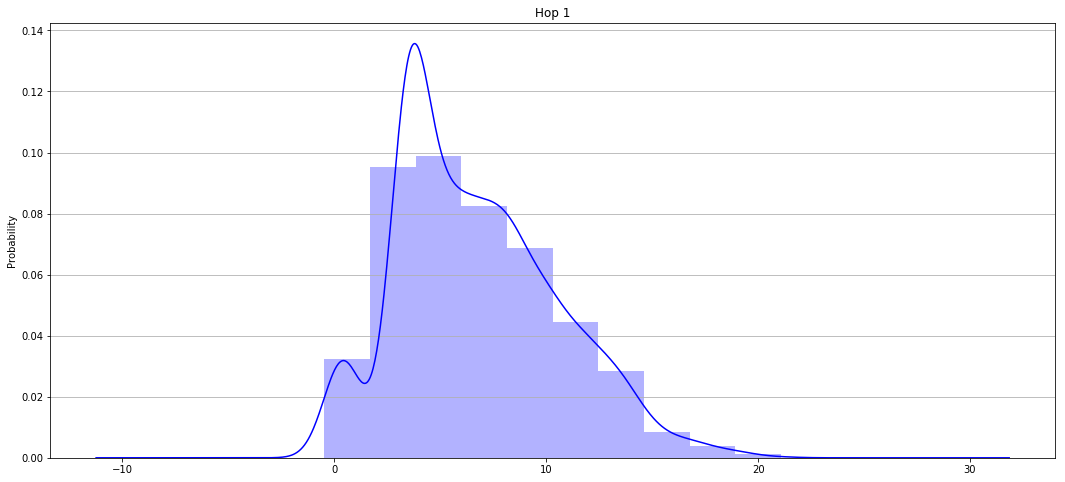

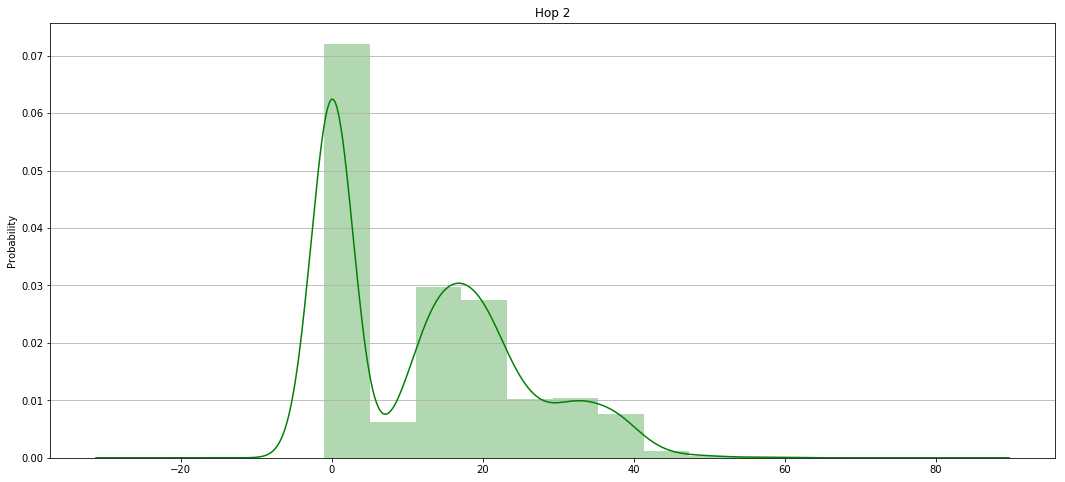

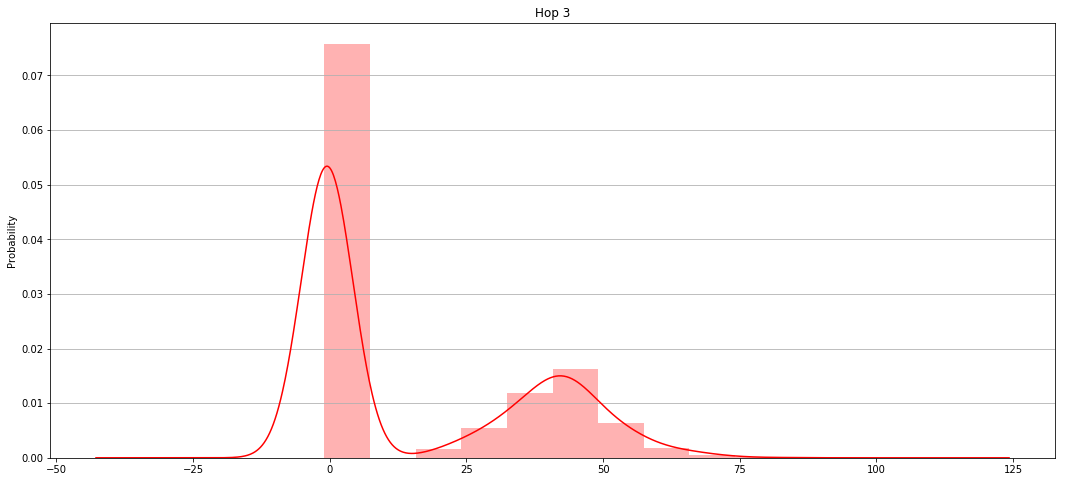

In [52]:
for hop in hop_nodes:
    fig, ax = plt.subplots(figsize=(18,8))
    if hop == 1:
        hop_nodes[hop].plot.kde(ax=ax,color='blue', title='Hop ' + str(hop))
        hop_nodes[hop].plot.hist(density=True,color='blue',alpha=0.3, ax=ax)
    elif hop == 2:
        hop_nodes[hop].plot.kde(ax=ax,color='green', title='Hop ' + str(hop))
        hop_nodes[hop].plot.hist(density=True,color='green',alpha=0.3, ax=ax)
    else:
        hop_nodes[hop].plot.kde(ax=ax,color='red', title='Hop ' + str(hop))
        hop_nodes[hop].plot.hist(density=True,color='red',alpha=0.3, ax=ax)
    ax.set_ylabel('Probability')
    ax.grid(axis='y')

As you can see, it seems that nodes communicating directly with the root have lower probability of timeouts, while the stability of messages degrades as we move away. Thus, the probability of having a timeout seems to increase as the distance from root increases. Let's check.

In [53]:
pd.DataFrame([[h, str(hop_nodes[h].loc[hop_nodes[h] < 0].count()/hop_nodes[h].count()*100)+'%'] for h in hops], \
             columns=['Hop','Probability of error'])

,Hop,Probability of error
0,1,0.2%
1,2,22.3%
2,3,43.9%


It is also interesting to see how the time to complete 2000 pings varies as the distance from the root increases.

In [48]:
time_nodes = {}
for h in hops:
    for time in hop_nodes[h].keys():
        if h not in time_nodes:
            if hop_nodes[h][time] < 0:
                time_nodes[h] = [0.0]
            else:
                time_nodes[h] = [hop_nodes[h][time]]
        else:
            if hop_nodes[h][time] < 0:
                time_nodes[h].append(time_nodes[h][-1])
            else:
                time_nodes[h].append(time_nodes[h][-1] + hop_nodes[h][time])

time_nodes = pd.DataFrame(time_nodes) 
time_nodes.tail(1)

,1,2,3
1999,13490.911333,24355.3375,31095.897


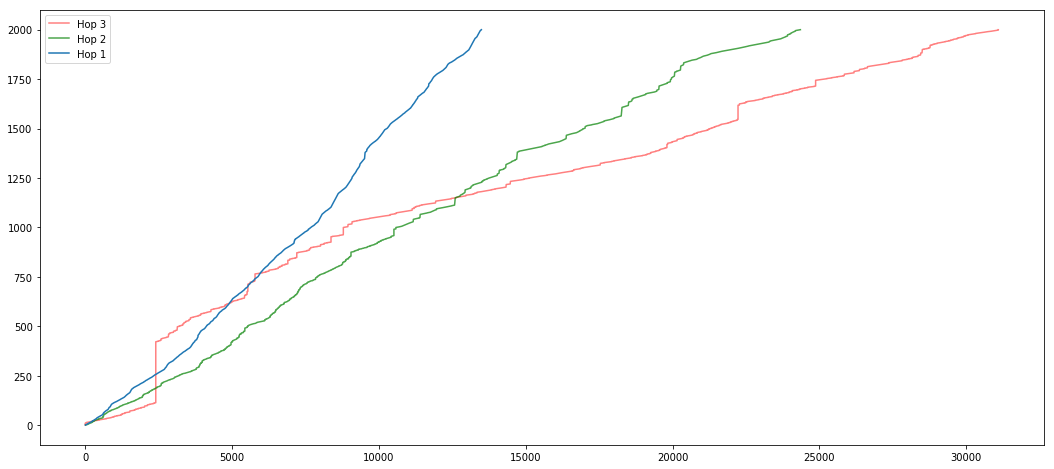

In [49]:
fig, ax = plt.subplots(figsize=(18,8))

# Using plot(..., dashes=...) to set the dashing when creating a line
line3, = ax.plot(time_nodes[3], icmp, 'red', alpha=0.5, label='Hop 3')

# Using plot(..., dashes=...) to set the dashing when creating a line
line2, = ax.plot(time_nodes[2], icmp, 'green', alpha=0.7, label='Hop 2')

# Using set_dashes() to modify dashing of an existing line
line1, = ax.plot(time_nodes[1], icmp, label='Hop 1')

ax.legend()
plt.show()